# **Izhikevich Model**  

The [**Izhikevich model**](https://www.izhikevich.org/publications/spikes.pdf) is a computationally efficient model of neuron dynamics that captures a wide range of spiking and bursting behaviors observed in biological neurons. It is defined by two differential equations:  

$$
\begin{cases}
\dot{v} = 0.04v^2 + 5v + 140 - u + I \\
\dot{u} = a(bv - u)
\end{cases}
$$

where:  
- v represents the membrane potential,  
- u is a recovery variable,  
- I is the external input current,  
- a, b, c, d are parameters that define different neuron types.  

When v reaches a threshold (e.g., 30 mV), it is reset:  

$$v \leftarrow c, \quad u \leftarrow u + d $$

Here we have some of the behaviour that can be expressed by the Izhikevich model:

![image.png](izhikevich.png)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive
import sympy as sp
import seaborn as sns
sns.set_theme(style="darkgrid")

In [3]:
def izhikevic_model(a, b, c, d, dt, T, I_ext, v0=-70, w0=-15):
    """Simulates the Izhikevich neuron model."""
    
    time = np.arange(0, T, dt)
    max_value = 30  # Maximum spike value
    
    V = np.zeros(len(time))
    V[0] = v0  # Initial membrane potential (mV)
    w = np.zeros(len(time))
    w[0] = w0  # Initial recovery variable
    
    if isinstance(I_ext, (int, float)):
        I = np.full(len(time), I_ext)  # Constant input current (used for the phase plane)
    else:
        I = I_ext # Time-varying input current
    
    for t in range(1, len(time)):
        # check that the membrane potential is not higher than the maximum value
        if V[t - 1] < max_value:
            # membran potential evolution
            # calculate the increment
            dV = (0.04 * V[t - 1] + 5) * V[t - 1] + 140 - w[t - 1]
            # update the membrane potential (update the state variable)
            V[t] = V[t - 1] + (dV + I[t - 1]) * dt

            # recovery variable evolution
            dw = a * (b * V[t - 1] - w[t - 1])
            w[t] = w[t - 1] + dt * dw

        # everytime V[t-1]>max_value we have a spike
        else:
            # peak reached
            V[t - 1] = max_value
            # peak reached
            V[t] = c
            # reset recovery variable
            w[t] = w[t - 1] + d
    
    return time, V, w

def compute_nullclines(a, b, I):
    """Compute nullclines for V and w."""
    V_range = np.linspace(-85, 35, 100)
    
    # V-nullcline: dV/dt = 0 → I = w - (0.04*V^2 + 5V + 140)
    V_null = 0.04 * V_range**2 + 5 * V_range + 140 + I
    
    # w-nullcline: dw/dt = 0 → w = bV
    u_null = b * V_range

    return V_range, V_null, u_null

def compute_vector_field(a, b, I):
    """Compute the vector field in phase space."""
    V_vals = np.linspace(-85, 35, 20)
    u_vals = np.linspace(-20, 15, 20)
    
    V, w = np.meshgrid(V_vals, u_vals)

    dV = (0.04 * V**2 + 5 * V + 140 - w) + I
    dw = a * (b * V - w)

    magnitude = np.sqrt(dV**2 + dw**2)
    dV_norm = dV / (magnitude + 1e-6)
    du_norm = dw / (magnitude + 1e-6)

    return V, w, dV_norm, du_norm

def find_critical_point(a, b, I):
    """Solve system equations to find the critical point in phase space."""
    V_sym, u_sym = sp.symbols('V w')
    
    eq1 = 0.04 * V_sym**2 + 5 * V_sym + 140 - u_sym + I  # dV/dt = 0
    eq2 = a * (b * V_sym - u_sym)  # dw/dt = 0
    
    c_p = sp.solve((eq1, eq2), (V_sym, u_sym))

    # Filter only real solutions
    real_solutions = [(float(sol[0]), float(sol[1])) for sol in c_p if sol[0].is_real and sol[1].is_real]
  
    if real_solutions:
        return real_solutions
    return None 


def plot_time_evolution(a, b, c, d, dt, T, I_ext, v0=-70):
    """Plots the time evolution of the Izhikevich neuron model."""

    time, V, w = izhikevic_model(a, b, c, d, dt, T, I_ext=I_ext, v0=v0)

    fig, axes = plt.subplots(2, 1, figsize=(10, 6))

    # plot the stimulus
    axes[0].plot(time,I_ext)
    axes[0].set_xlabel('Time (ms)')
    axes[0].set_ylabel('Current (pA)')
    axes[0].set_title('Input Current')

    # plotting the model output
    axes[1].plot(time, V)
    axes[1].set_xlabel('Time (ms)')
    axes[1].set_ylabel('Membrane Potential (mV)')
    axes[1].set_title('Izhikevic model')
    
    plt.tight_layout()
    plt.show()


def plot_phase_plane(I_ext, a, b, c, d, v0=-70, w0=-15):
    """Plots the phase plane, nullclines, vector field, and voltage trace."""
    dt = 0.1  
    T = 200   

    time, V, w = izhikevic_model(a, b, c, d, dt, T, I_ext, v0, w0)

    V_range, V_null, u_null = compute_nullclines(a, b, I_ext)
    V_grid, u_grid, dV_grid, du_grid = compute_vector_field(a, b, I_ext)
    critical_points = find_critical_point(a, b, I_ext)

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Voltage over time
    axes[0].plot(time, V, label="V(t)")
    axes[0].plot(time, w, label="w(t)")
    axes[0].set_xlabel("Time (ms)")
    axes[0].set_ylabel("State variable")
    axes[0].set_title("Time Evolution")
    axes[0].legend()

    # Phase plane: V vs. w
    axes[1].plot(V_range, V_null, label=r"$\dot v = 0$", color='blue')
    axes[1].plot(V_range, u_null, label=r"$\dot w = 0$", color='green')
    
    # Plot vector field
    axes[1].quiver(V_grid, u_grid, dV_grid, du_grid, color="gray", alpha=0.5, scale=30)

    # Plot neuron trajectory
    axes[1].plot(V, w, color='red', label="trajectory")

    # Mark critical point
    if critical_points:
        for cp in critical_points:
            cp_x, cp_y = cp
            axes[1].plot(cp_x, cp_y, 'r*', markersize=8)

    # starting position
    axes[1].plot(V[0], w[0], 'bo', label='start', markersize=8)

    axes[1].set_xlabel("V (Membrane Potential mV)")
    axes[1].set_ylabel("w (Recovery Variable)")
    axes[1].set_title("Phase Plane")
    axes[1].legend(loc='upper right')
    axes[1].grid()
    axes[1].set_xlim(-85,35)
    axes[1].set_ylim(-20,15)

    plt.show()

# Create interactive widget
interactive_plot = interactive(
    plot_phase_plane,
    a=widgets.FloatSlider(min=0.02, max=0.1, step=0.01, value=0.02, description='a'),
    b=widgets.FloatSlider(min=0.2, max=0.27, step=0.01, value=0.2, description='b'),
    c=widgets.IntSlider(min=-65, max=-50, step=1, value=-65, description='c'),
    d=widgets.IntSlider(min=0.05, max=8, step=1, value=2, description='d'),
    I_ext=widgets.FloatSlider(min=0, max=20, step=1, value=10, description='I_ext'),
    v0=widgets.IntSlider(min=-70, max=30, step=1, value=-70, description='V0'),
    w0=widgets.IntSlider(min=-20, max=10, step=1, value=-15, description='w0')
)

interactive_plot


interactive(children=(FloatSlider(value=10.0, description='I_ext', max=20.0, step=1.0), FloatSlider(value=0.02…

In [4]:
# Parameters for different neuron types
params = {
    'RS': {'a': 0.02, 'b': 0.2, 'c': -65, 'd': 8},
    'IB': {'a': 0.02, 'b': 0.2, 'c': -55, 'd': 4},
    'CH': {'a': 0.02, 'b': 0.2, 'c': -50, 'd': 2},
    'FS': {'a': 0.1, 'b': 0.2, 'c': -65, 'd': 2},
    'LTS': {'a': 0.02, 'b': 0.25, 'c': -65, 'd': 2},
    'TC': {'a': 0.02, 'b': 0.25, 'c': -65, 'd': 0.05},
    'RZ': {'a': 0.1, 'b': 0.26, 'c': -65, 'd': 2},
}

# setting time and input current (for the lineplot)
T = 1000 # simulation len
dt = 0.5 # time step for the integration
time_series = np.arange(0,T,dt)
I = 10 # current step amplitude 
I_ = np.zeros(len(time_series)) 
I_ [200:1500] = I # we stop at 1.5s

---

## Regular Spiking (RS)

RS neurons are the most typical neurons in the
cortex. When presented with a prolonged stimulus, the neurons fire a few spikes
with short interspike period and then the period increases. Increasing the strength of
the injected dc-current increases the interspike frequency, though
it never becomes too fast because of large spike-afterhyperpolar-
izations. In the model, this corresponds to c = 65 mV (deep
voltage reset) and d = 8 (large after-spike jump of u).

$
\begin{cases}
a = 0.02 \\
b = 0.2 \\
c = -65 \\
d = 8
\end{cases}
$

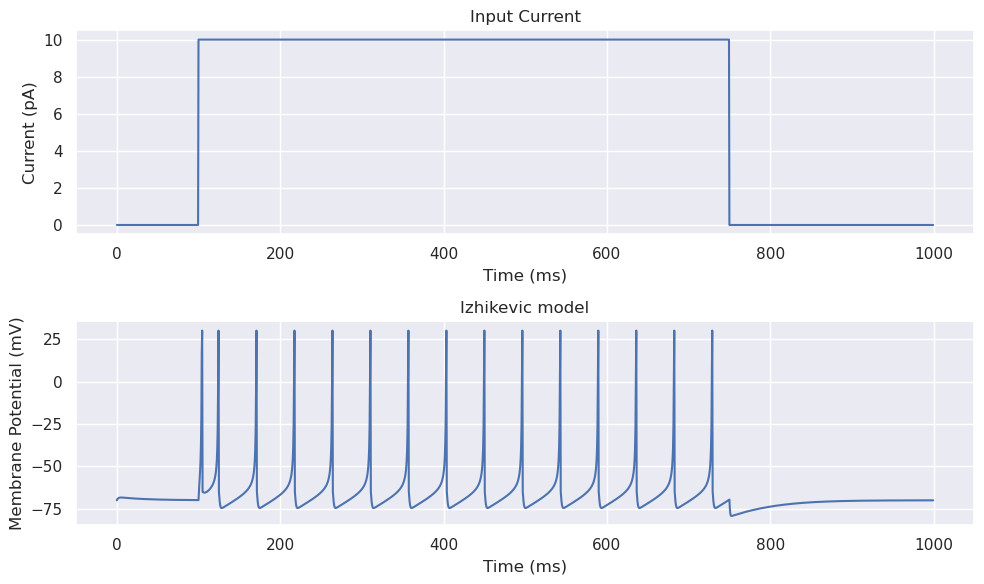

interactive(children=(FloatSlider(value=10.0, description='I', max=20.0, step=1.0), Output()), _dom_classes=('…

In [5]:
# get parameters
a, b, c, d = params['RS'].values()

# plot the time evolution
plot_time_evolution(a, b, c, d, dt, T, I_)

# Create interactive widget
interactive_plot = interactive(
    lambda I_ext: plot_phase_plane(I_ext, a=a, b=b, c=c, d=d),
    I_ext=widgets.FloatSlider(min=0, max=20, step=1, value=10, description='I')
)
interactive_plot

## Intrinsically Bursting (IB)

IB neurons fire a stereotypical burst of
spikes followed by repetitive single spikes. In the
model, this corresponds to c = 55 mV (high voltage reset)
and d = 4 (large after-spike jump of u). During the initial burst,
variable u builds up and eventually switches the dynamics from
bursting to spiking.

$
\begin{cases}
a = 0.02 \\
b = 0.2 \\
c = -55 \\
d = 4
\end{cases}
$

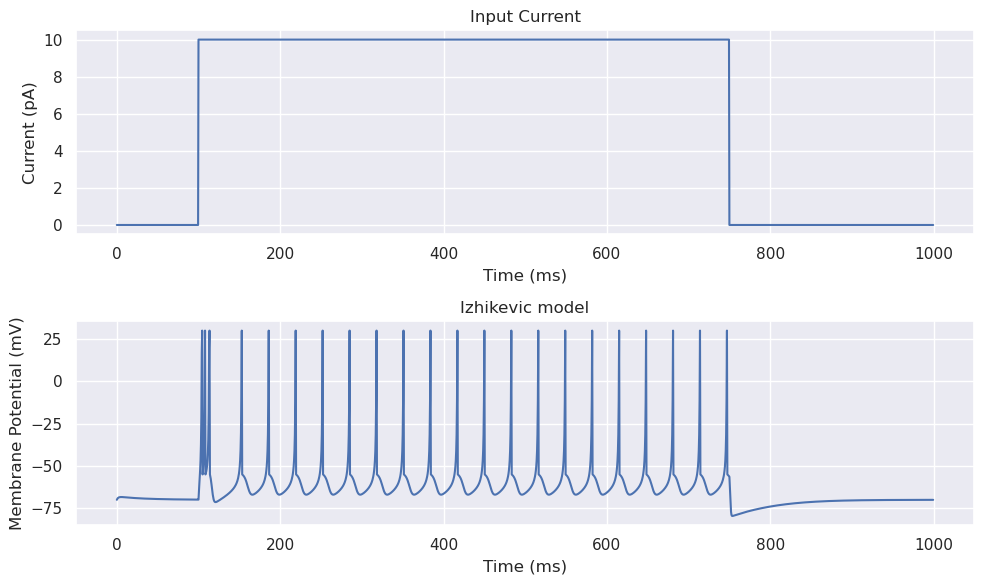

interactive(children=(FloatSlider(value=10.0, description='I', max=20.0, step=1.0), Output()), _dom_classes=('…

In [6]:
# get parameters
a, b, c, d = params['IB'].values()

# plot the time evolution
plot_time_evolution(a, b, c, d, dt, T, I_)

# Create interactive widget
interactive_plot = interactive(
    lambda I_ext: plot_phase_plane(I_ext, a=a, b=b, c=c, d=d),
    I_ext=widgets.FloatSlider(min=0, max=20, step=1, value=10, description='I')
)
interactive_plot

## Chattering (CH)

CH neurons can fire stereotypical bursts of closely
spaced spikes. The inter-burst frequency can be as high as 40 Hz.
In the model, this corresponds to c = 50 mV (very high voltage
reset) and d = 2 (moderate after-spike jump of u).

$
\begin{cases}
a = 0.02 \\
b = 0.2 \\
c = -50 \\
d = 2
\end{cases}
$

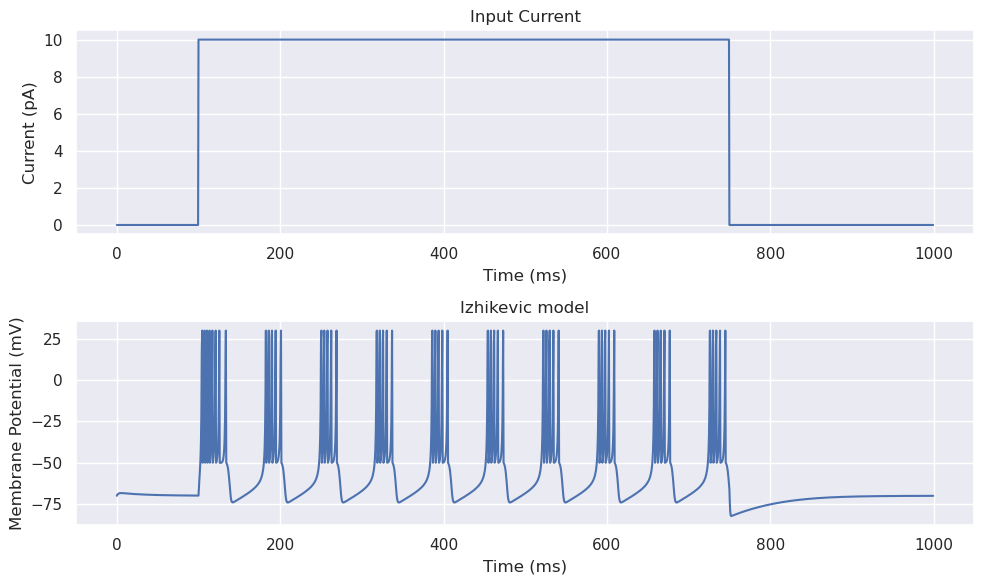

interactive(children=(FloatSlider(value=10.0, description='I', max=20.0, step=1.0), Output()), _dom_classes=('…

In [7]:
# get parameters
a, b, c, d = params['CH'].values()

# plot the time evolution
plot_time_evolution(a, b, c, d, dt, T, I_)

# Create interactive widget
interactive_plot = interactive(
    lambda I_ext: plot_phase_plane(I_ext, a=a, b=b, c=c, d=d),
    I_ext=widgets.FloatSlider(min=0, max=20, step=1, value=10, description='I')
)
interactive_plot

## Fast Spiking (FS)

FS neurons can fire periodic trains of action potentials 
with extremely high frequency practically without any adaptation 
(slowing down). In the model,
this corresponds to a = 0.1 (fast recovery).

$
\begin{cases}
a = 0.1 \\
b = 0.2 \\
c = -65 \\
d = 2
\end{cases}
$

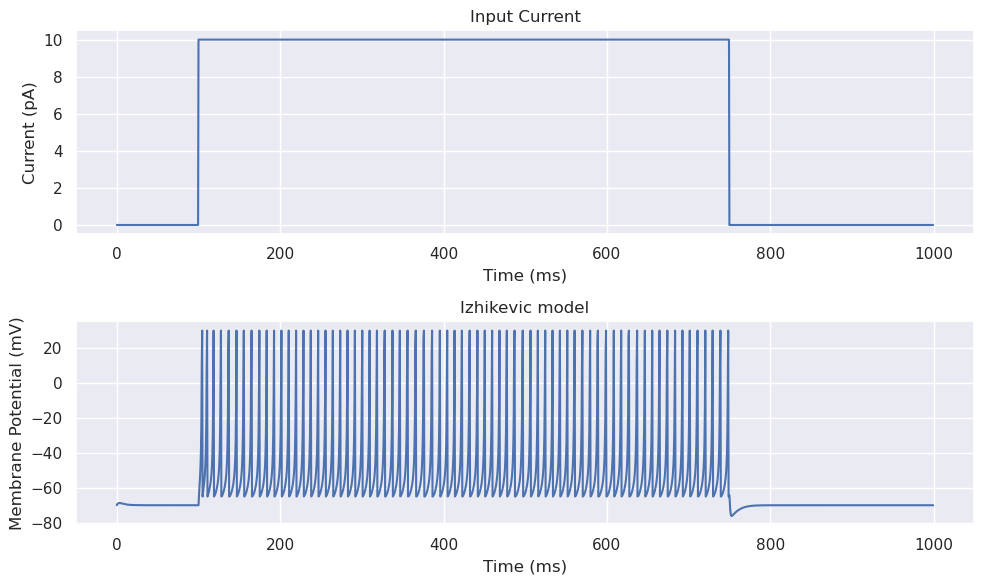

interactive(children=(FloatSlider(value=10.0, description='I', max=20.0, step=1.0), Output()), _dom_classes=('…

In [8]:
# get parameters
a, b, c, d = params['FS'].values()

# plot the time evolution
plot_time_evolution(a, b, c, d, dt, T, I_)

# Create interactive widget
interactive_plot = interactive(
    lambda I_ext: plot_phase_plane(I_ext, a=a, b=b, c=c, d=d),
    I_ext=widgets.FloatSlider(min=0, max=20, step=1, value=10, description='I')
)
interactive_plot

## Low-Threshold Spiking (LTS)

LTS neurons can also fire high-frequency
trains of action potentials, but with a noticeable spike
frequency adaptation. These neurons have low firing thresholds,
which is accounted for by b = 0.25 in the model. 

$
\begin{cases}
a = 0.02 \\
b = 0.25 \\
c = -65 \\
d = 2
\end{cases}
$

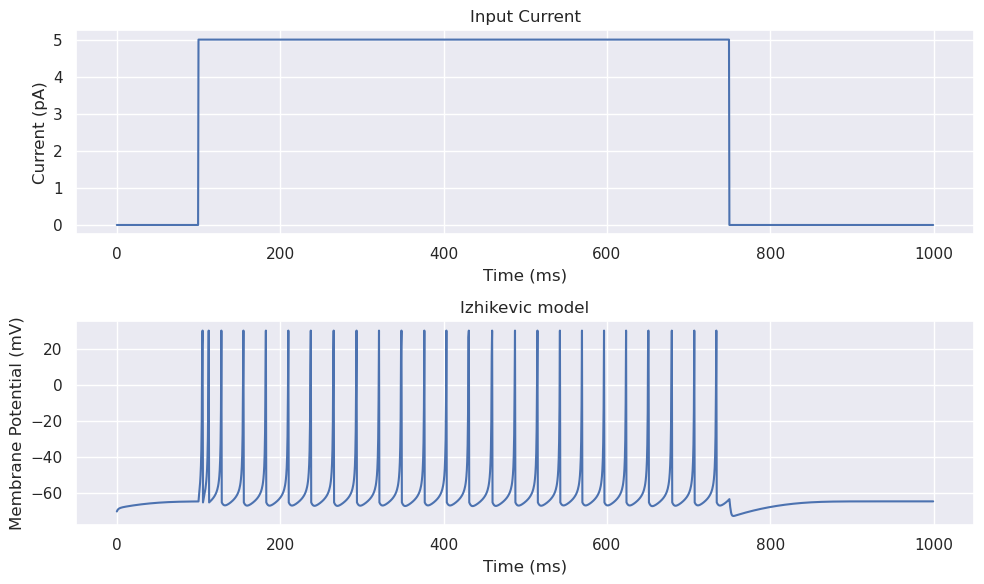

interactive(children=(FloatSlider(value=5.0, description='I', max=20.0, step=1.0), Output()), _dom_classes=('w…

In [9]:
# get parameters
a, b, c, d = params['LTS'].values()

# we get a good spiking output even with a low current
I_lts = 5
I_lts_ = np.zeros(len(time_series))
I_lts_[200:1500] = I_lts

# plot the time evolution
plot_time_evolution(a, b, c, d, dt, T, I_lts_)

# Create interactive widget
interactive_plot = interactive(
    lambda I_ext: plot_phase_plane(I_ext, a=a, b=b, c=c, d=d),
    I_ext=widgets.FloatSlider(min=0, max=20, step=1, value=5, description='I')
)
interactive_plot

## Thalamo-Cortical (TC)

TC neurons have two firing regimes: When
at rest (v is around 60 mV) and then depolarized, they exhibit tonic firing. However, if a 
negative current step is delivered so that the membrane potential is
hyperpolarized (v is around 90 mV), the neurons fire a rebound
burst of action potentials.

$
\begin{cases}
a = 0.02 \\
b = 0.25 \\
c = -65 \\
d = 0.05
\end{cases}
$

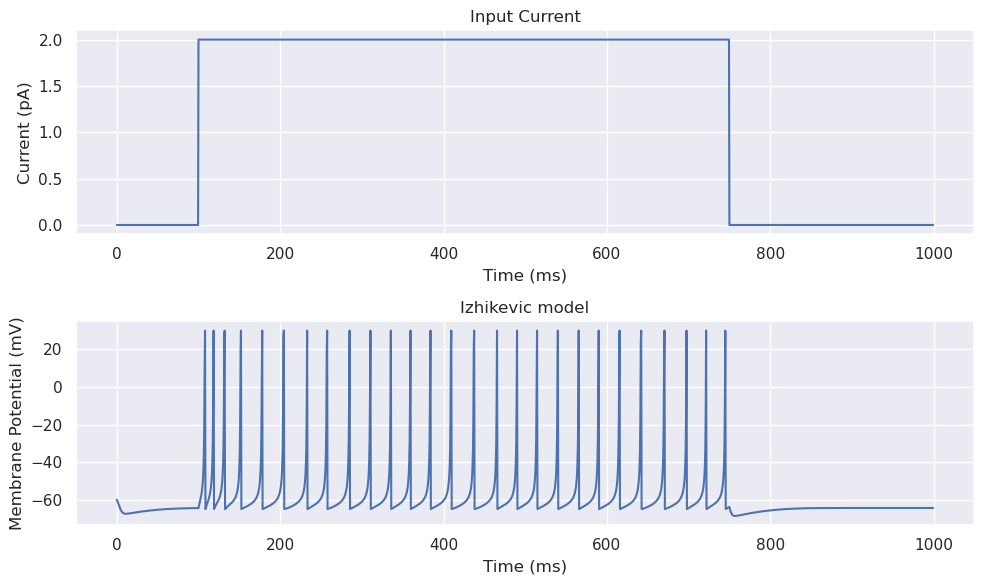

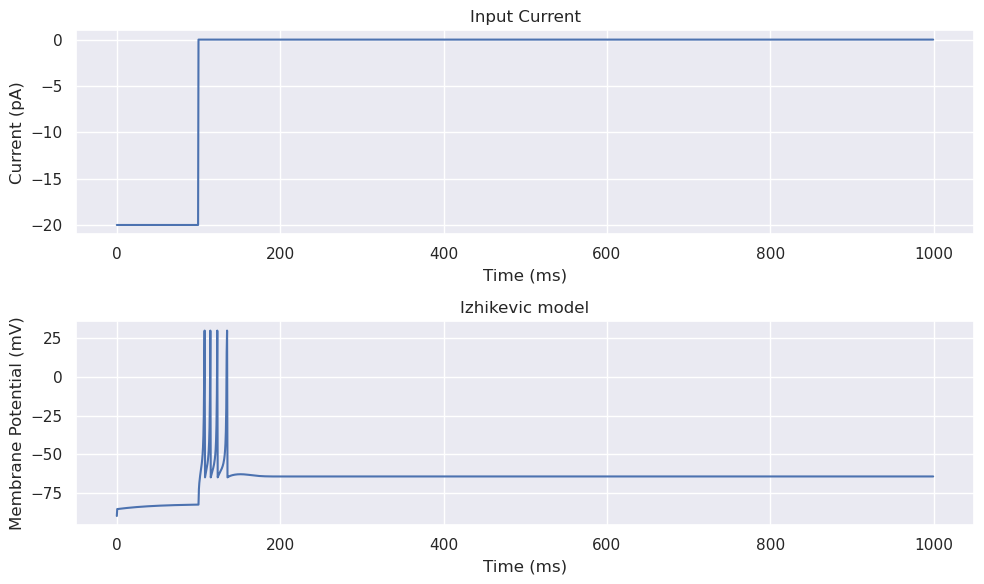

interactive(children=(FloatSlider(value=2.0, description='I', max=20.0, step=1.0), Output()), _dom_classes=('w…

In [10]:
# get parameters
a, b, c, d = params['TC'].values()

# firing regime 1: tonic spiking
I_tc = 2
I_tc_ = np.zeros(len(time_series))
I_tc_[200:1500] = I_tc
plot_time_evolution(a, b, c, d, dt, T, I_tc_, v0=-60)

# firing regime 2: rebound burst
I_tc = -20
I_tc_ = np.zeros(len(time_series))
I_tc_[:200] = I_tc
plot_time_evolution(a, b, c, d, dt, T, I_tc_, v0=-90)

# Create interactive widget
interactive_plot = interactive(
    lambda I_ext: plot_phase_plane(I_ext, a=a, b=b, c=c, d=d),
    I_ext=widgets.FloatSlider(min=0, max=20, step=1, value=2, description='I')
)
interactive_plot

## Resonator (RZ)

RZ neurons have damped or sustained subthreshold
oscillations. They resonate to rhythmic inputs
having appropriate frequency. This behavior corresponds to a = 0.1 and b = 0.26.
Notice that there is a bistability of resting and repetitive spiking
states: The neuron can be switched between the states by an
appropriately timed brief stimuli.

$
\begin{cases}
a = 0.1 \\
b = 0.26 \\
c = -65 \\
d = 2
\end{cases}
$

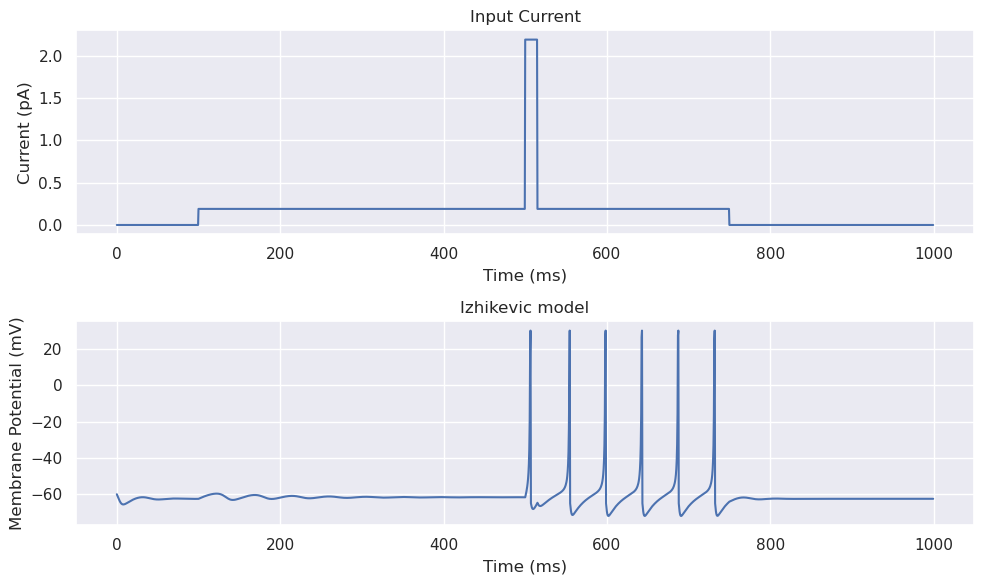

interactive(children=(FloatSlider(value=3.0, description='I', max=20.0, step=1.0), Output()), _dom_classes=('w…

In [11]:
# get parameters
a, b, c, d = params['RZ'].values()

# plot the time evolution
I_rz = 0.19
I_rz_ = np.zeros(len(time_series))
I_rz_[200:1500] = I_rz
I_rz_[1000:1030] = I_rz + 2
plot_time_evolution(a, b, c, d, dt, T, I_rz_, v0=-60)

# Create interactive widget
interactive_plot = interactive(
    lambda I_ext: plot_phase_plane(I_ext, a=a, b=b, c=c, d=d),
    I_ext=widgets.FloatSlider(min=0, max=20, step=1, value=3, description='I')
)
interactive_plot

## Integrator

The Integrator neuron doesn't fire immidieately when a current is supplied

$
\begin{cases}
a = 0.02 \\
b = -0.1 \\
c = -55 \\
d = 6
\end{cases}
$

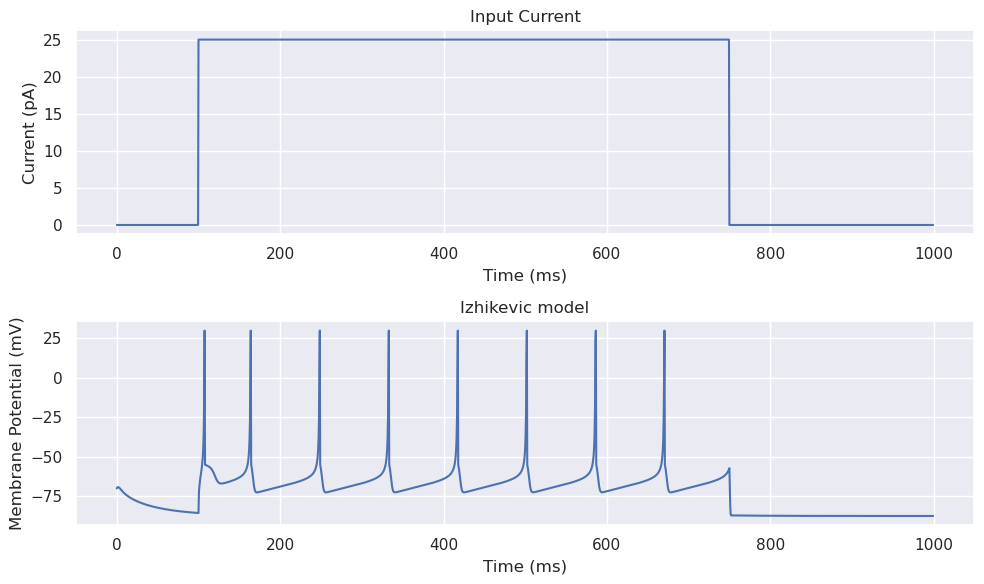

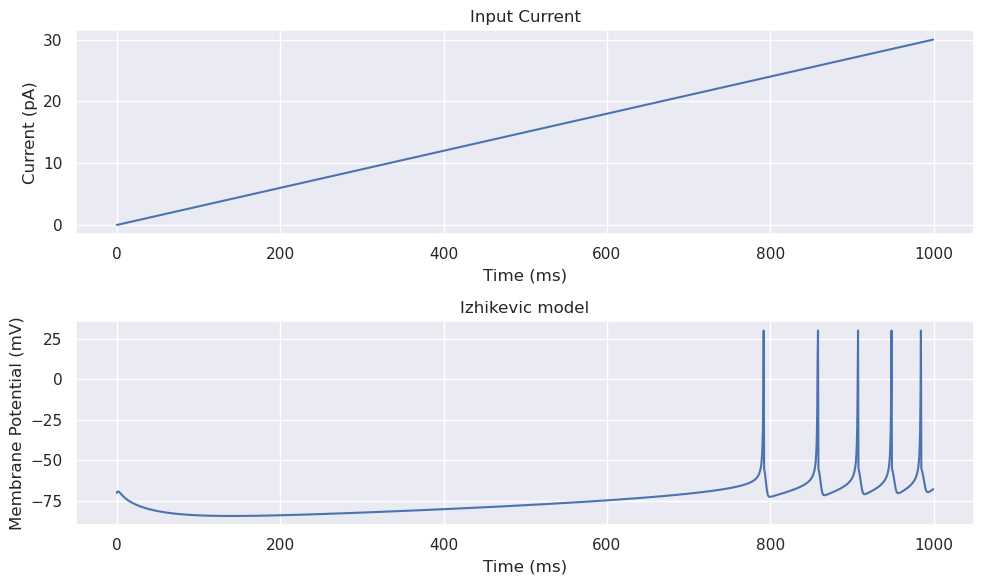

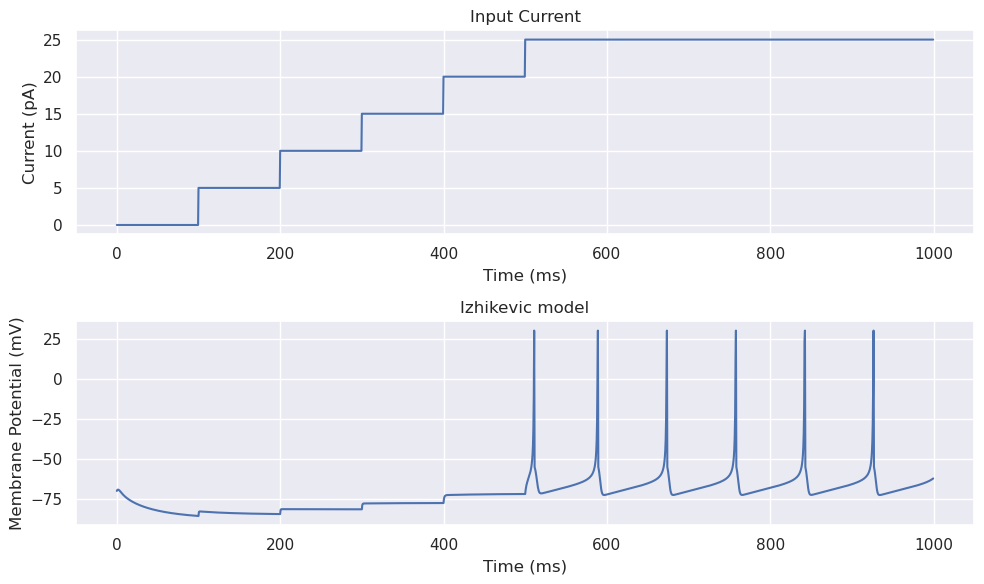

interactive(children=(FloatSlider(value=10.0, description='I', max=20.0, step=1.0), Output()), _dom_classes=('…

In [12]:
# get parameters
a, b, c, d = 0.02, -0.1, -55, 6

# constant input current
I_1 = 25
I_1_ = np.zeros(len(time_series))
I_1_[200:1500] = I_1
plot_time_evolution(a, b, c, d, dt, T, I_1_)

I_2 = 0.03 * time_series
plot_time_evolution(a, b, c, d, dt, T, I_2)

I_3 = np.zeros(len(time_series))
I_3[200:400] = 5
I_3[400:600] = 10
I_3[600:800] = 15
I_3[800:] = 20
I_3[1000:] = 25
plot_time_evolution(a, b, c, d, dt, T, I_3)


# Create interactive widget
interactive_plot = interactive(
    lambda I_ext: plot_phase_plane(I_ext, a=a, b=b, c=c, d=d),
    I_ext=widgets.FloatSlider(min=0, max=20, step=1, value=10, description='I')
)
interactive_plot

---

# Sparse network of spiking cortical neurons

We are going to see a sparse network of spiking cortical neurons, one example of spiking neural network proposed by Izhikevic in his article ['Simple model of spiking neurons'](https://www.izhikevich.org/publications/spikes.pdf)

Let's simulate a network of randomly connected 1000 neurons in real time. The ratio of excitatory to inhibitory neurons is 4:1 to match by the anatomy of a mammalian cortex.
First approximation:
- RS cells to model all excitatory neurons (RS gives a regular spiking);
- FS cells to model all inhibitory neurons (FS gives a fast and irregular spiking).

**Heterogeneity**: different neurons have different dynamics. To ensure heterogeneity it is necessary:
- Assign each excitatory cell $(a_i; b_i)$ = (0.02; 0.2) and $(c_i; d_i)$ =(-65; 8) + (15;6)$r^2_i$, where $r_i$ is a random variable uniformly distributed on the interval [0,1], and i is the neuron index. Thus, ri = 0
corresponds to regular spiking (RS) cell, and $r_i$ = 1 corresponds to the chattering (CH) cell. Use $r^2_i$
to bias the distribution toward RS. We have a random component on $c$ and $d$ for the excitatory cells.
- Similarly, each inhibitory cell has $(a_i; b_i)$ = (0.02; 0.25) + (0.08;0.05)$r_i$ and $(c_i; d_i)$=(-65,2). We have a random component on $a$ and $b$ for the inhibitory cells.


Synaptic Weight Matrix Shape:  (1000, 1000)


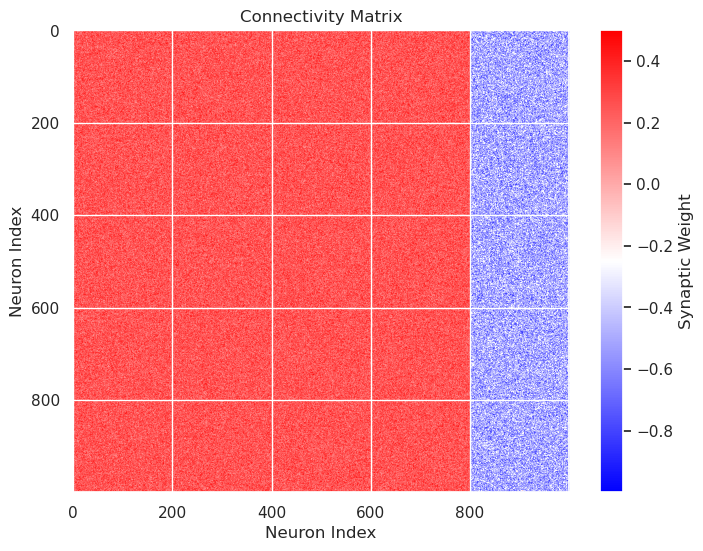

In [85]:
np.random.seed(42)

# parameters
Ne = 800    # number of exc neurons
Ni = 200    # number of inh neurons
thr = 30    # voltange threshold
time_span = 1000    # sim time

# extract the random numbers r for each neuron in [0,1]
# heterogeneity variables for exc and inh populations
### we jsut extrac a random sample
### Ne = number of exc neurons
### Ni = number of inh neurons
re = np.random.rand(Ne,1) # excitatory neurons
ri = np.random.rand(Ni,1) # inhibitory neurons


# set the parameters for izhikevic model of each neuron
# as seen before we compute our values for a,b,c,d
a = np.concatenate((0.02*np.ones((Ne,1)), 0.02 + 0.08*ri))
b = np.concatenate((0.2*np.ones((Ne,1)), 0.25 - 0.05*ri))
c = np.concatenate((-65 + 15*re**2, -65*np.ones((Ni,1))))
d = np.concatenate((8 - 6*re**2, 2*np.ones((Ni,1))))

# initial values for v and u for each neuron
v = -65*np.ones((Ne + Ni,1))
u = b*v

# setting synaptic connection weights (randomly connected network)
S = np.concatenate((0.5*np.random.rand(Ne + Ni,Ne),-np.random.rand(Ne + Ni,Ni)),1)
# we obtain a matrix of connectivity
print("Synaptic Weight Matrix Shape: ", S.shape)
plt.figure(figsize=(8, 6))
plt.imshow(S, cmap='bwr', aspect='auto')
plt.colorbar(label='Synaptic Weight')
plt.title('Connectivity Matrix')
plt.xlabel('Neuron Index')
plt.ylabel('Neuron Index')
plt.show()

Integrate numerically the equations for each neurons and collect the spikes.
Suppose that all the neurons are receiving a fixed current given by an ideal **thalamic input**.

In [68]:
import time

spike_times = np.array([[0,0]])

start = time.time()
# simulation loop
for t in range(time_span):
    # thalamic input
    I = np.concatenate((5*np.random.randn(Ne,1),2*np.random.randn(Ni,1)),0)
    # spike indices: get the neurons that are spiking
    fired = np.where(v>=thr)[0]
    # if I have some spike, I will store the spike time and the indexes of the neurons that are spiking
    if fired is not None:
        firing = np.concatenate((t*np.ones((len(fired),1)), fired.reshape(-1,1)),1) # 2D: (spike time, neuron index)
        spike_times = np.concatenate((spike_times,firing))
        # updating v and u
        # we have to apply the reset condition for all the neurons that are spiking
        # fired is the indexes of the neurons that are spiking
        v[fired] = c[fired]
        u[fired] = u[fired] + d[fired]

        # add the contribution of the neurons that are spiking
        I += S[:,fired].sum(1).reshape(-1,1)

    # + I : contribution to the connectivity
    v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I) # dt = 0.5
    v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I) # dt = 0.5
    u = u + a*(b*v - u)


print(f'Simulation time: {time.time() - start:.2f} s')

Simulation time: 0.26 s


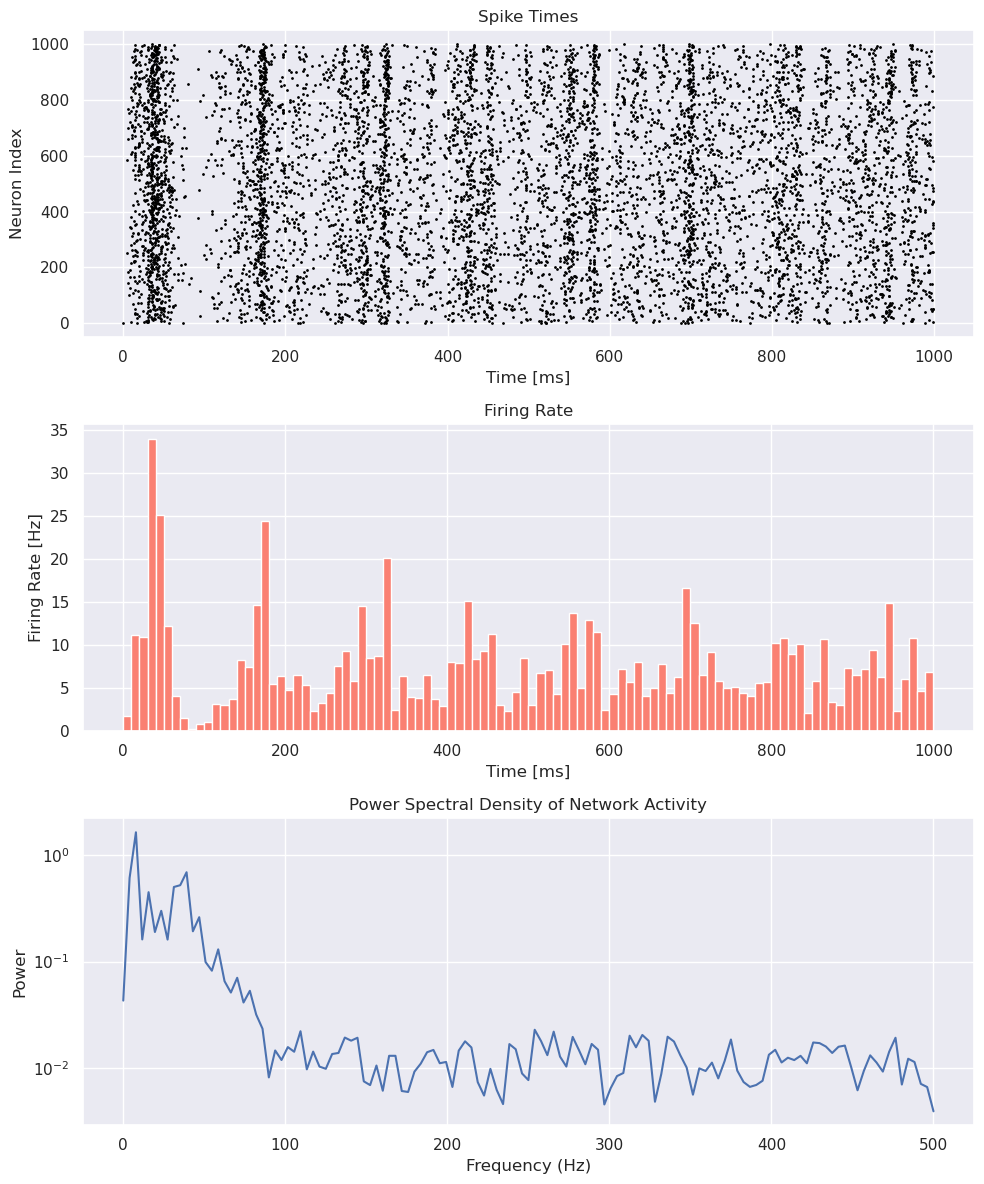

In [ ]:
from scipy.signal import welch

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

#### RASTER PLOT
ax1.scatter(spike_times[:, 0], spike_times[:, 1], s=1, color='black')
ax1.set_xlabel('Time [ms]')
ax1.set_ylabel('Neuron Index')
ax1.set_title('Spike Times')


#### FIRING RATE
bin_size = 10
bins = np.arange(0, 1000 + bin_size, bin_size)
spike_counts, _ = np.histogram(spike_times[:, 0], bins)
num_neurons = 1000
firing_rate_timeseries = spike_counts / (bin_size / 1000.0 * num_neurons)
ax2.bar(bins[:-1], firing_rate_timeseries, label='Firing Rate', width=bin_size, align='edge', color='salmon')
ax2.set_xlabel('Time [ms]')
ax2.set_ylabel('Firing Rate [Hz]')
ax2.set_xlim(-50, 1050)
ax2.set_title('Firing Rate')


### POWER SPECTRAL DENSITY
# Create the Spike Matrix. a binary matrix of shape (num_neurons, num_bins)
time_bins = np.arange(0, time_span + 1, 1)
num_bins = len(time_bins)
# Initialize the binary spike matrix
spike_matrix = np.zeros((num_neurons, num_bins), dtype=int)
# Fill the binary matrix
for spike_time, neuron_id in spike_times:
    bin_idx = int(np.round(spike_time / dt))  # Find time bin
    if bin_idx < num_bins:  # Prevent out-of-bounds errors
        spike_matrix[int(neuron_id), bin_idx] = 1  # Mark spike

# Summing over neurons to get the population firing rate
PFR = np.sum(spike_matrix, axis=0)
# Compute Power Spectral Density (PSD) of the PFR
# T = duration of the signal (1000)
frequencies, power = welch(PFR, fs=T, nperseg=256)

# Plot the Power Spectrum
ax3.semilogy(frequencies, power)
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('Power')
ax3.set_title('Power Spectral Density of Network Activity')

plt.tight_layout()
plt.show()


Already from the raster plot and the firing rate we can see that the neurons are higly synchronized. In the plot of the Power Spectral Density (PSD), computed with the Welch's method, we can see a few dominant frequency peaks in the PSD of the population firing rate, so the network is synchronized. This happens because we are giving an input to the system.

---

# Small-world network

A [small-world network](http://www.scholarpedia.org/article/Small-world_network) refers to a network in which the shortest-path between nodes increases sufficiently slowly as a function of the number of nodes in the network.

![image.png](small-world.png)

For creating the a Small-World Network we follow this steps:
1. Use the [Watts-Strogatz model](https://en.wikipedia.org/wiki/Watts%E2%80%93Strogatz_model) to generate connectivity.
2. Each neuron connects to its k nearest neighbors.
3. Some connections are randomly rewired with probability p

The other parameters are identical to the previous network, only the connections changes.

- excitatory cells: $(a_i; b_i)$ = (0.02; 0.2) and $(c_i; d_i)$ =(65; 8) + (15;6)$r^2_i$
- inhibitory cells: $(a_i; b_i)$ = (0.02; 0.25) + (0.08;0.05)$r_i$ and $(c_i; d_i)$=(65,2)
    
    where $r_i$ is a r.v. uniformly distributed on [0,1], and i is the neuron index.


Synaptic Weight Matrix Shape:  (1000, 1000)


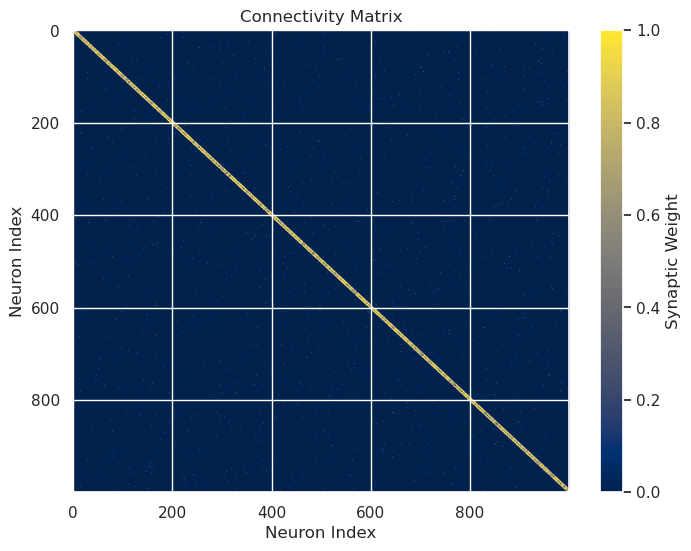

In [ ]:
import networkx as nx

# Parameters
Ne = 800    # Number of excitatory neurons
Ni = 200    # Number of inhibitory neurons
N = Ne + Ni # Total number of neurons
thr = 30    # Voltage threshold
time_span = 1000  # Simulation time (ms)
k = 10      # Average degree of connectivity
p = 0.1     # Rewiring probability

# Generate small-world network
G = nx.watts_strogatz_graph(N, k, p)
S = nx.to_numpy_array(G)

# Random heterogeneity
re = np.random.rand(Ne,1)
ri = np.random.rand(Ni,1)

a = np.concatenate((0.02*np.ones((Ne,1)), 0.02 + 0.08*ri))
b = np.concatenate((0.2*np.ones((Ne,1)), 0.25 - 0.05*ri))
c = np.concatenate((-65 + 15*re**2, -65*np.ones((Ni,1))))
d = np.concatenate((8 - 6*re**2, 2*np.ones((Ni,1))))

# Initial conditions
v = -65*np.ones((N,1))
u = b * v

print("Synaptic Weight Matrix Shape: ", S.shape)
plt.figure(figsize=(8, 6))
plt.imshow(S, aspect='auto', cmap='cividis')
plt.colorbar(label='Synaptic Weight')
plt.title('Connectivity Matrix')
plt.xlabel('Neuron Index')
plt.ylabel('Neuron Index')
plt.show()

In [87]:
spike_times = []

dt = 1  # Time step

# Simulation loop
for t in range(time_span):
    I = np.concatenate((5*np.random.randn(Ne,1), 2*np.random.randn(Ni,1)), 0)
    fired = np.where(v >= thr)[0]
    if fired.size > 0:
        for neuron in fired:
            spike_times.append((t, neuron))
        v[fired] = c[fired]
        u[fired] += d[fired]
        I += S[:, fired].sum(1).reshape(-1,1)
    v += 0.5 * (0.04 * v**2 + 5 * v + 140 - u + I)
    v += 0.5 * (0.04 * v**2 + 5 * v + 140 - u + I)
    u += a * (b*v - u)

spike_times = np.array(spike_times)

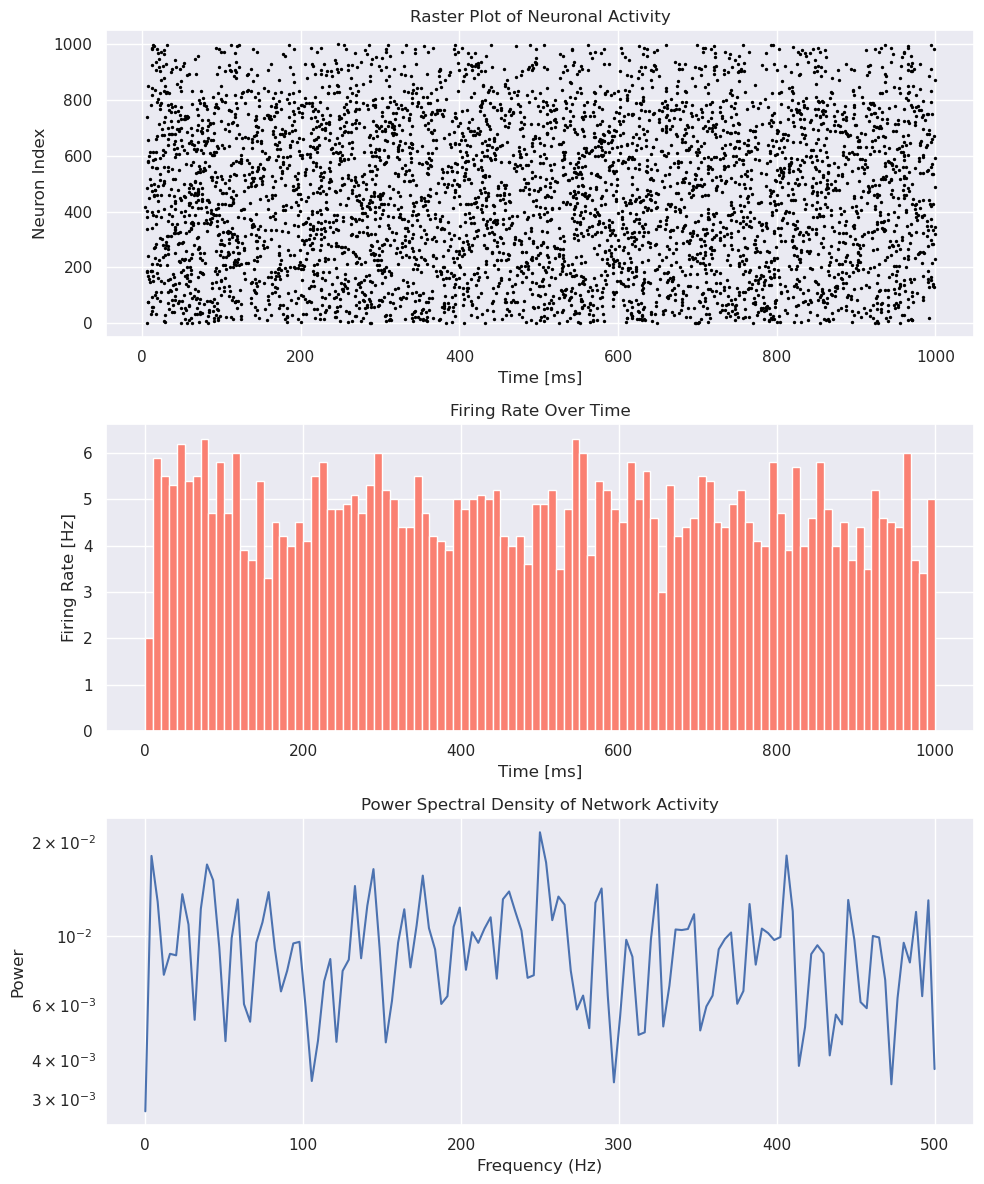

In [88]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

# Raster Plot
ax1.scatter(spike_times[:, 0], spike_times[:, 1], s=2, color='black')
ax1.set_xlabel('Time [ms]')
ax1.set_ylabel('Neuron Index')
ax1.set_title('Raster Plot of Neuronal Activity')

# Firing Rate Histogram
bin_size = 10
bins = np.arange(0, time_span + bin_size, bin_size)
spike_counts, _ = np.histogram(spike_times[:, 0], bins)
firing_rate_timeseries = spike_counts / (bin_size / 1000.0 * N)
ax2.bar(bins[:-1], firing_rate_timeseries, width=bin_size, align='edge', color='salmon')
ax2.set_xlabel('Time [ms]')
ax2.set_ylabel('Firing Rate [Hz]')
ax2.set_title('Firing Rate Over Time')

# Power Spectral Density
num_bins = time_span // dt
spike_matrix = np.zeros((N, num_bins), dtype=int)
for spike_time, neuron_id in spike_times:
    bin_idx = int(np.round(spike_time / dt))
    if bin_idx < num_bins:
        spike_matrix[int(neuron_id), bin_idx] = 1
PFR = np.sum(spike_matrix, axis=0)
frequencies, power = welch(PFR, fs=1000, nperseg=256)
ax3.semilogy(frequencies, power)
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('Power')
ax3.set_title('Power Spectral Density of Network Activity')

plt.tight_layout()
plt.show()


The small-world network structure prevents excessive synchronization, leading to a more stable and heterogeneous firing pattern. The small world network shows integrated information, in which the neurons are connected in a way that they are both specialized and functionally integrated.